# Imports

In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import csv
import pickle
from sklearn.model_selection import train_test_split

# Input pipeline and preprocessing

## Classifier

### Create classification datasets

For creating the datasets, the training images, test images and test labels have to be downloaded and extracted. They should be saved in the `data` directory, with a structure like this:

```plaintext
data/
    classifier/
        Training/
            00000/
                ...
            00001/
                ...
        Test/
            00000.ppm
            ...
            GT-final_test.csv
```    

In [ ]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath, is_test=False):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    
    if not is_test:
        images = [] # images
        labels = [] # corresponding labels
        # loop over all 42 classes
        for c in range(0,43):
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
                # TODO: Add not only the label but also the location of the bounding box
                labels.append(row[7]) # the 8th column is the label
            gtFile.close()
        return images, labels
    
    if is_test:
        # test images are not in seperate directories and have one annotation file with all annotations
        images = [] # images
        labels = []
        prefix = rootpath + '/'
        gtFile = open(prefix + 'GT-final_test.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            # TODO: Add not only the label but also the location of the bounding box
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
        return images, labels

X, y = readTrafficSigns('./data/Training')
X_test, y_test = readTrafficSigns('./data/Test', is_test=True)

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=21)

# Dictionaries erstellen
train = {'features': X_train, 'labels': y_train}
val = {'features': X_val, 'labels': y_val}
test  = {'features': X_test,  'labels': y_test}

# Speichern
with open('./data/classifier/classifier_train.pkl', 'wb') as f:
    pickle.dump(train, f)
with open('./data/classifier/classifier_valid.pkl', 'wb') as f:
    pickle.dump(val, f)
with open('./data/classifier/classifier_test.pkl', 'wb') as f:
    pickle.dump(test, f)

### Visualization

In [ ]:
training_file   = './data/classifier/classifier_train.pkl'
validation_file = './data/classifier/classifier_valid.pkl'
testing_file    = './data/classifier/classifier_test.pkl'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
X_valid, y_valid = valid['features'], valid['labels'] # validation dataset used in training phase
X_test, y_test   = test['features'], test['labels']   # test dataset
n_classes        = len(np.unique(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
#assert(len(X_test) == len(y_test))

print()
print("Image Shape    : {}".format(X_train[0].shape))
print()
print("Training Set   : {} samples".format(len(X_train)))
print("Validation Set : {} samples".format(len(X_valid)))
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
X_train[0].shape
#X_train.shape


Image Shape    : (46, 50, 3)

Training Set   : 35288 samples
Validation Set : 3921 samples
Test Set       : 12630 samples
n_classes      : 43


(46, 50, 3)

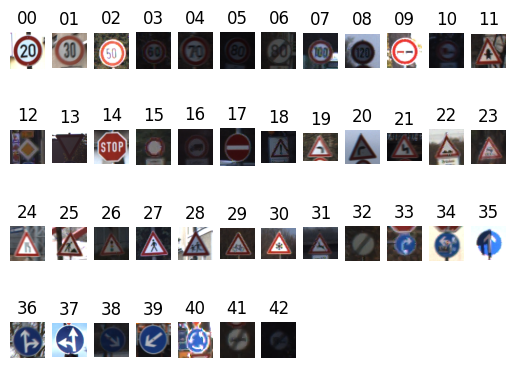

In [ ]:
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plt.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        # get X_train of the current class
        X_train_of_class = [X_train[i] for i in range(len(X_train)) if y_train[i] == str(idx)]
        # show a random image of the current class
        X_train_0       = X_train_of_class[np.random.randint(len(X_train_of_class))]
        ax.imshow(X_train_0)
        ax.set_title('{:02d}'.format(idx))
        ax.axis('off')
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plt.draw()
fig.savefig('figures/' + 'sample_representative' + '.jpg', dpi=700)

## Object detection

### Create datasets

In [2]:
# function for converting Roi.X1;Roi.Y1;Roi.X2;Roi.Y2 labels to X.center, Y.center, Width, Height
# Roi.X1 and Roi.Y1 are the coordinates of the top left corner of the bounding box, with Roi.X2 and Roi.Y2 being the bottom right corner
def convert_bbox_label(label, image_size=None):
    '''Converts bounding box label from (Roi.X1, Roi.Y1, Roi.X2, Roi.Y2) format to YOLO format (X.center, Y.center, Width, Height).'''
    if image_size is None:
        raise ValueError("Image size must be provided to convert bounding box label.")
    x1, y1, x2, y2 = label
    roi_width  = x2 - x1
    roi_height = y2 - y1
    roi_x_center = x1 + roi_width / 2
    roi_y_center = y1 + roi_height / 2
    
    # Normalize coordinates to [0, 1] range
    width, height = image_size
    roi_x_center /= width
    roi_y_center /= height
    roi_width /= width
    roi_height /= height
    return f"{roi_x_center} {roi_y_center} {roi_width} {roi_height}"

#### Training + validation datasets

In [ ]:
os.makedirs('./data/yolo_detection/train/images', exist_ok=True)
os.makedirs('./data/yolo_detection/train/labels', exist_ok=True)

# copy over folders from valid classes
# stop sign: 14
# other stopping signs: 15, 17
# priority signs: 11, 12, 13
valid_classes = [11, 12, 13, 14, 15, 17]

for img_class in valid_classes:
    # select subfolder of the current class
    subfolder = f"{img_class:05d}"
    
    # copy over all images and labels of the current class
    # dst image should be in './data/yolo_detection/train/images' with name '{subfolder}_{original_name}.jpg'
    src_images = f'./data/classifier/Training/{subfolder}'
    
    for filename in os.listdir(src_images):
        if filename.endswith('.ppm'):
            # read the image
            img = Image.open(os.path.join(src_images, filename))
            # convert to RGB and save as JPEG
            img = img.convert('RGB')
            new_filename = f"{subfolder}_{filename[:-4]}.jpg"
            img.save(f'./data/yolo_detection/train/images/{new_filename}')
            
            # get label data from the CSV file
            label_file = f'./data/classifier/Training/{subfolder}/GT-{subfolder}.csv'
            df = pd.read_csv(label_file, sep=';')
            # find the row corresponding to the current image
            row = df[df['Filename'] == filename].iloc[0]
            # extract bounding box coordinates
            bbox_coords = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
            
            # create label file in YOLO format
            label_file = f'./data/yolo_detection/train/labels/{new_filename[:-4]}.txt'
            with open(label_file, 'w') as f:
                # convert bounding box label to YOLO format
                bbox_label = convert_bbox_label(bbox_coords, image_size=(img.width, img.height))
                f.write(f"{img_class} {bbox_label}\n")

In [ ]:
os.makedirs('./data/yolo_detection/val/images', exist_ok=True)
os.makedirs('./data/yolo_detection/val/labels', exist_ok=True)

# split of 10% of the training data to validation data
train_images = os.listdir('./data/yolo_detection/train/images')

# split stratified by class, randomized with random_state=21
train_images, valid_images = train_test_split(train_images, test_size=0.1, random_state=21, stratify=[img.split('_')[0] for img in train_images])

# move over validation images and labels
for filename in valid_images:
    # move image
    src_image = f'./data/yolo_detection/train/images/{filename}'
    dst_image = f'./data/yolo_detection/val/images/{filename}'
    shutil.move(src_image, dst_image)
    
    # move label
    src_label = f'./data/yolo_detection/train/labels/{filename[:-4]}.txt'
    dst_label = f'./data/yolo_detection/val/labels/{filename[:-4]}.txt'
    shutil.move(src_label, dst_label)

In [ ]:
# print number of images per class
train_labels = os.listdir('./data/yolo_detection/train/labels')
valid_labels = os.listdir('./data/yolo_detection/val/labels')
class_counts = {}
for label in train_labels:
    with open(os.path.join('./data/yolo_detection/train/labels', label), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
print("Number of images per class in the train detection dataset:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")
    
print()

class_counts = {}
for label in valid_labels:
    with open(os.path.join('./data/yolo_detection/val/labels', label), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
print("Number of images per class in the valid detection dataset:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

Number of images per class in the train detection dataset:
Class 11: 1188 images
Class 12: 1890 images
Class 13: 1944 images
Class 14: 702 images
Class 15: 567 images
Class 17: 999 images

Number of images per class in the valid detection dataset:
Class 11: 132 images
Class 12: 210 images
Class 13: 216 images
Class 14: 78 images
Class 15: 63 images
Class 17: 111 images


#### Test dataset

In [5]:
# Convert test folder to YOLO format
# create a images folder and a labels folder
# for each image in the test set, create a corresponding label file in YOLO format (txt) should be in the labels folder
# copy over test from classifier to an new detection folder
os.makedirs('./data/yolo_detection/test/images', exist_ok=True)
os.makedirs('./data/yolo_detection/test/labels', exist_ok=True)

# copy labels csv file to the detection folder
shutil.copy('./data/classifier/Test/GT-final_test.csv', './data/yolo_detection/test/GT-final_test.csv')

# remove all labels, which do not belong these classes:
# stop sign: 14
# other stopping signs: 15, 17
# priority signs: 11, 12, 13
test_df = pd.read_csv('./data/classifier/Test/GT-final_test.csv', delimiter=';')
valid_classes = [11, 12, 13, 14, 15, 17]
test_df = test_df[test_df['ClassId'].isin(valid_classes)]
# save the filtered test_df to a new csv file
test_df.to_csv('./data/yolo_detection/test/GT-final_test.csv', index=False, sep=';')

In [6]:
# copy images, which are still in the test_df
test_df = pd.read_csv('./data/yolo_detection/test/GT-final_test.csv', delimiter=';')
for file in test_df['Filename']:
    # copy the image to the images folder
    # convert it to jpg
    img_path = os.path.join('./data/classifier/Test', file)
    img = Image.open(img_path)
    img = img.convert('RGB')
    img.save(os.path.join('./data/yolo_detection/test/images', file.replace('.ppm', '.jpg')))
    
    # create a label file in the labels folder
    label_file = file.replace('.ppm', '.txt')
    label_path = os.path.join('./data/yolo_detection/test/labels', label_file)
    with open(label_path, 'w') as f:
        # get the label from the test csv
        test_df = pd.read_csv('./data/classifier/Test/GT-final_test.csv', delimiter=';')
        row = test_df[test_df['Filename'] == file]
        img_size = img.size
        orig_label = (row['Roi.X1'].values[0], row['Roi.Y1'].values[0], row['Roi.X2'].values[0], row['Roi.Y2'].values[0])
        yolo_label = convert_bbox_label(orig_label, image_size=img_size)
        # write the label to the file
        f.write(f"{row['ClassId'].values[0]} {yolo_label}\n")

# remopve the csv file
os.remove('./data/yolo_detection/test/GT-final_test.csv')

In [7]:
# print number of images per class
labels = os.listdir('./data/yolo_detection/test/labels')
class_counts = {}
for label in labels:
    with open(os.path.join('./data/yolo_detection/test/labels', label), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
print("Number of images per class in the test detection dataset:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

Number of images per class in the test detection dataset:
Class 11: 420 images
Class 12: 690 images
Class 13: 720 images
Class 14: 270 images
Class 15: 210 images
Class 17: 360 images


### Create yaml file

In [ ]:
# create a data.yaml file for YOLO
# TODO: if relative paths are not working, use absolute paths
data_yaml_content = f"""
train: './data/yolo_detection/train'
val: './data/yolo_detection/val'
nc: 6

names:
  11: 'intersection ahead'
  12: 'priority road'
  13: 'yield'
  14: 'stop'
  15: 'no vehicles permitted'
  17: 'no entry'
"""

# write the data.yaml file
with open('./data/yolo_detection/data.yaml', 'w') as f:
    f.write(data_yaml_content)
    
# print the content of the data.yaml file
print("data.yaml content:")
print(data_yaml_content)

data.yaml content:

train: './data/yolo_detection/train'
val: './data/yolo_detection/val'
nc: 6

names:
  11: 'intersection ahead'
  12: 'priority road'
  13: 'yield'
  14: 'stop'
  15: 'no vehicles permitted'
  17: 'no entry'



### Show example visualization

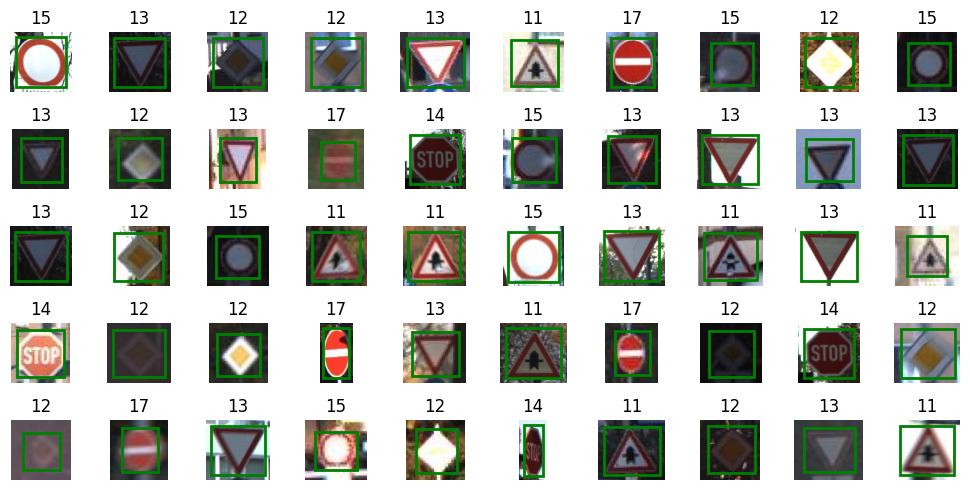

In [36]:
# visualize some images from the test set with their labels
test_images = os.listdir('./data/yolo_detection/test/images')
rows, cols = 5, 10
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(test_images):
        # randomly select an image from the test set
        img_file = test_images[np.random.randint(len(test_images))]
        img = Image.open(os.path.join('./data/yolo_detection/test/images', img_file))
        ax.imshow(img)
        ax.axis('off')
        
        # read the label file
        label_file = img_file.replace('.jpg', '.txt')
        with open(os.path.join('./data/yolo_detection/test/labels', label_file), 'r') as f:
            label = f.read().strip()
        
        # show label roi on the image
        if label:
            class_id, bbox = label.split(' ', 1)
            bbox = list(map(float, bbox.split()))
            x_center, y_center, width, height = bbox
            
            # convert to pixel coordinates
            img_width, img_height = img.size
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)
            
            # draw rectangle on the image
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.set_title(class_id)
        
    else:
        ax.axis('off')

plt.tight_layout()
fig.savefig('figures/' + 'detection_sample_representative' + '.jpg', dpi=700)

# Training

In [ ]:
# ...

# Evaluation

In [ ]:
# ...